In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# Device configuration (GPU o CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Ruta donde se almacenarán los datos CelebAGaze
root = '../../Laboratories/Lab05/datasets/CelebAGaze'

# Transformaciones de datos
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.flatten()),
    transforms.Lambda(lambda x: x * 2. - 1.)
])

# Cargar datos de entrenamiento
train = ImageFolder(root=root, transform=transform)

In [4]:
dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True) # type: ignore
imgs, _ = next(iter(dataloader))
imgs.shape, imgs.dtype, imgs.min(), imgs.max()

(torch.Size([32, 12288]), torch.float32, tensor(-1.), tensor(1.))

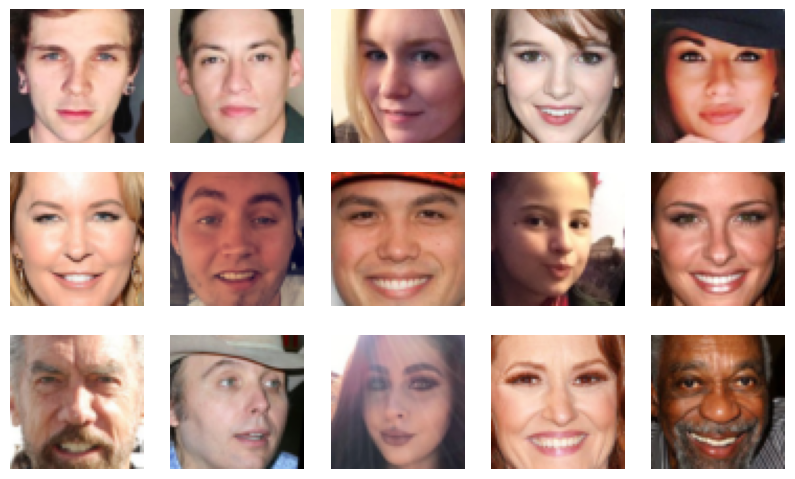

In [5]:
import random
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
    for ax in _ax:
        ix = random.randint(0, len(train)-1)
        img, lab = train[ix]
        ax.imshow(img.reshape(3,64,64).permute(1,2,0)*0.5+0.5)
        ax.axis('off')
plt.show()

In [ ]:
fig = plt.figure()
ax = plt.subplot(1, 2, 1)
noise = torch.randn(28, 28, 3) # ruido 
ax.imshow(noise, cmap='gray')
ax.axis('off')
ax = plt.subplot(1, 2, 2)
sample = torch.from_numpy(X[0])
ax.imshow(sample, cmap='gray')
ax.axis('off')
plt.tight_layout()
plt.show()